# PERSIANN Data Analysis

In [1]:
# data wrangling
import pandas as pd
import numpy as np

# image processing
from PIL import Image
import matplotlib.pyplot as plt

# geo data processing
from osgeo import gdal
from osgeo import osr

import georasters as gr
import geopandas as gpd

# utils
import glob
import os
from struct import unpack # binary data
import gzip
import shutil

/home/adriel-martins/.cache/pypoetry/virtualenvs/wm-tAk-yGEW-py3.8/lib/python3.8/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
input_file = '../data/ms6s4_d21362.bin.gz'
output_file = '../data/ms6s4_d21362.bin'
with gzip.open(input_file, 'rb') as f_in:
    with open(output_file, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [3]:
# inputfile
BinaryFile = '../data/ms6s4_d21362.bin' # Make sure you adjust the location.
 
# open binary file
f = open(BinaryFile, 'rb')
 
# set file dimensions
xs = 1440 # 180 / 0.25 (our resolution for longitude)
ys = 480 # 60 / 0.25  (our resolution for latitude)
 
# set number of bytes in file
NumbytesFile = xs * ys
 
# number of columns in row
NumElementxRecord = -xs
 
# create empty array to put data in
myarr = []
 
# loop trough the binary file row by row
for PositionByte in range(NumbytesFile,0, NumElementxRecord):
 
        Record = ''
 
        # the dataset starts at 0 degrees, use 720 to convert to -180 degrees
        for c in range (PositionByte-720, PositionByte, 1):
                f.seek(c * 4)
                DataElement = unpack('>f', f.read(4))
                Record = Record  + str("%.2f" % DataElement + ' ')
        
        # 0 - 180 degrees
        for c in range (PositionByte-1440 , PositionByte-720, 1):
                f.seek(c * 4)
                DataElement = unpack('>f', f.read(4))
                Record = Record  + str("%.2f" % DataElement + ' ')
 
        # add data to array
        myarr.append(Record[:-1].split(" "))
 
# close binary file
f.close()
 
# Array to numpy float
myarr = np.array(myarr).astype('float')
 
# mirror array
myarr = myarr[::-1]
 
# set values some values to non data
myarr[myarr < 0] = 0
myarr[np.isnan(myarr)] = 0

# define output name
outname = "../data/ms6s4_d21362.tiff"
 
# set coordinates
originy = -60
originx  = -180
pixelsize = 0.25
transform= (originx, pixelsize, 0.0, originy, 0.0, -pixelsize)
driver = gdal.GetDriverByName( 'GTiff' )
 
# set projection
target = osr.SpatialReference()
target.ImportFromEPSG(4326)
 
## write dataset to disk
outputDataset = driver.Create(outname, xs,ys, 1,gdal.GDT_Float32)
outputDataset.SetGeoTransform(transform)
outputDataset.SetProjection(target.ExportToWkt())
outputDataset.GetRasterBand(1).WriteArray(myarr)
outputDataset.GetRasterBand(1).SetNoDataValue(0)
outputDataset = None

Data (tiff image) shape: (480, 1440)


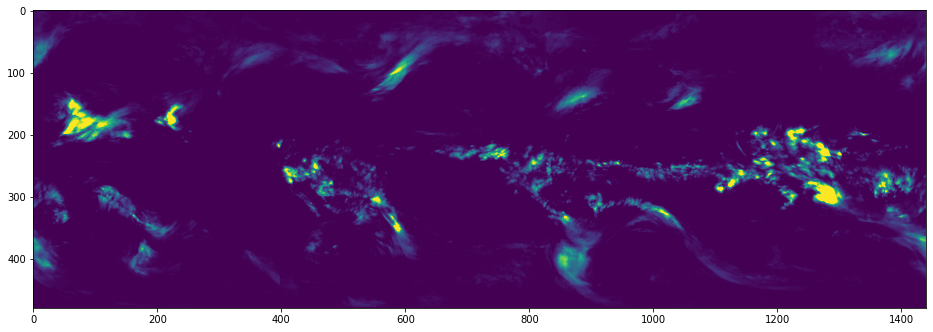

In [4]:
example_satellite_image_path = "../data/ms6s4_d21362.tiff"
example_img = np.asarray(Image.open(example_satellite_image_path, mode='r'))
print("Data (tiff image) shape:", example_img.shape)

plt.figure(figsize=(16, 32))
plt.imshow(myarr)
plt.clim(0, 50)

In [23]:
print(myarr.max(), myarr.mean())

210.34 1.8729733362268521


[35, -6]


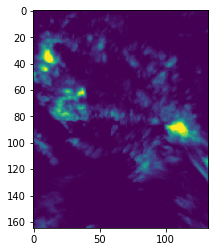

In [6]:
def get_bb_geoarr(example_img, lat_bb=None, lon_bb=None):
    if lat_bb is None:
        lat_bb = (-60, 60)
    if lon_bb is None:
        lon_bb = (-180, 180)
    
    lat_bb = [- i for i in lat_bb] # because it is changed from the norm that North is +, and South is -.

    lat_index_arr = np.arange(480)
    lon_index_arr = np.arange(1440)
    lat = np.arange(-60, 60, .25)
    lon = np.arange(-180, 180, .25)

    mask_lat = (lat >= lat_bb[1]) & (lat <= lat_bb[0])
    mask_lon = (lon >= lon_bb[0]) & (lon <= lon_bb[1])

    target_lat_index = lat_index_arr[mask_lat]
    target_lon_index = lon_index_arr[mask_lon]

    target_lat = lat[mask_lat]
    target_lon = lon[mask_lon]

    geoarr = np.zeros((target_lat_index.shape[0], target_lon_index.shape[0], 3))
    for i, lat_i in enumerate(target_lat_index):
        for j, lon_j in enumerate(target_lon_index):
            value = example_img[lat_i, lon_j]
            lat_value = -target_lat[i]
            lon_value = target_lon[j]
            geoarr[i, j] = np.array([value, lat_value, lon_value])
    s = geoarr.shape
    geoarr = geoarr.reshape(-1, 3)
    df = pd.DataFrame(geoarr, columns=['value', 'lat', 'lon'])
    return df, geoarr, s

df, geoarr, s = get_bb_geoarr(
    example_img,
    lat_bb=(-35, 6),
    lon_bb=(-69, -36)
)
aux = geoarr.reshape(s)[:, :, 0]

#plt.figure(figsize=(8, 16))
plt.imshow(aux)
plt.clim(0, 50)

In [8]:
geodata = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lon, df.lat))
geodata

,value,lat,lon,geometry
0,0.00,6.0,-69.00,POINT (-69.00000 6.00000)
1,0.00,6.0,-68.75,POINT (-68.75000 6.00000)
2,0.00,6.0,-68.50,POINT (-68.50000 6.00000)
3,0.00,6.0,-68.25,POINT (-68.25000 6.00000)
4,0.00,6.0,-68.00,POINT (-68.00000 6.00000)
...,...,...,...,...
21940,5.16,-35.0,-37.00,POINT (-37.00000 -35.00000)
21941,7.46,-35.0,-36.75,POINT (-36.75000 -35.00000)
21942,3.97,-35.0,-36.50,POINT (-36.50000 -35.00000)
21943,4.20,-35.0,-36.25,POINT (-36.25000 -35.00000)


320 500


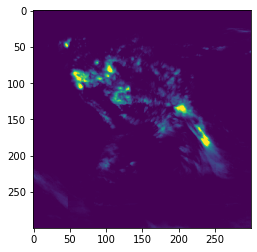

In [9]:
x = 320
y = 500
print(x, y)

k = 150
plt.imshow(example_img[int(x)-k:int(x)+k, int(y)-k:int(y)+k])
plt.clim(0, 50)

# Visualizing

<AxesSubplot:>

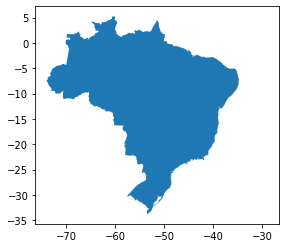

In [18]:
gadm = gpd.read_file(
    '../data/gadm/gadm36_BRA_1.shp'
).dissolve(
    by='NAME_0'
).drop(
    columns=[
        'GID_0', 'GID_1', 'NAME_1',
        'VARNAME_1', 'NL_NAME_1', 'TYPE_1',
        'ENGTYPE_1', 'CC_1', 'HASC_1'
    ]
)
gadm.plot()

In [19]:
geodata.set_crs(
    gadm.crs,
    inplace=True, allow_override=True
)

,value,lat,lon,geometry
0,0.00,6.0,-69.00,POINT (-69.00000 6.00000)
1,0.00,6.0,-68.75,POINT (-68.75000 6.00000)
2,0.00,6.0,-68.50,POINT (-68.50000 6.00000)
3,0.00,6.0,-68.25,POINT (-68.25000 6.00000)
4,0.00,6.0,-68.00,POINT (-68.00000 6.00000)
...,...,...,...,...
21940,5.16,-35.0,-37.00,POINT (-37.00000 -35.00000)
21941,7.46,-35.0,-36.75,POINT (-36.75000 -35.00000)
21942,3.97,-35.0,-36.50,POINT (-36.50000 -35.00000)
21943,4.20,-35.0,-36.25,POINT (-36.25000 -35.00000)


<Figure size 1152x2304 with 0 Axes>

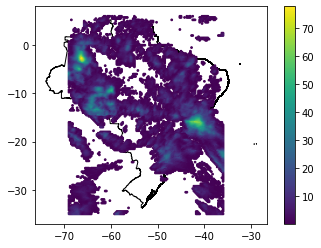

In [21]:
plt.figure(figsize=(16, 32))
ax = gadm.plot(color='white', edgecolor='black')

ax = geodata.query(
    'value > 0'
).plot(ax=ax, column='value', legend=True, markersize=3)

# All together now!

In [22]:
# def process_PERSIANN_gzbin_to_tif(gz_binfile):
#     gz_binfile = '../data/ms6s4_d21362.bin.gz'
#     binfile = '.'.join(gz_binfile.split('.')[0:-1])

#     with gzip.open(gz_binfile, 'rb') as f_in:
#         with open(binfile, 'wb') as f_out:
#             shutil.copyfileobj(f_in, f_out)

# process_PERSIANN_gzbin_to_tif('hsh')

In [ ]:
# def process_bin_to_tif(binfile, )

# # inputfile
# BinaryFile = '../data/ms6s4_d21362.bin' # Make sure you adjust the location.
 
# # open binary file
# f = open(BinaryFile, 'rb')
 
# # set file dimensions
# xs = 1440 # 180 / 0.25 (our resolution for longitude)
# ys = 480 # 60 / 0.25  (our resolution for latitude)
 
# # set number of bytes in file
# NumbytesFile = xs * ys
 
# # number of columns in row
# NumElementxRecord = -xs
 
# # create empty array to put data in
# myarr = []
 
# # loop trough the binary file row by row
# for PositionByte in range(NumbytesFile,0, NumElementxRecord):
 
#         Record = ''
 
#         # the dataset starts at 0 degrees, use 720 to convert to -180 degrees
#         for c in range (PositionByte-720, PositionByte, 1):
#                 f.seek(c * 4)
#                 DataElement = unpack('>f', f.read(4))
#                 Record = Record  + str("%.2f" % DataElement + ' ')
        
#         # 0 - 180 degrees
#         for c in range (PositionByte-1440 , PositionByte-720, 1):
#                 f.seek(c * 4)
#                 DataElement = unpack('>f', f.read(4))
#                 Record = Record  + str("%.2f" % DataElement + ' ')
 
#         # add data to array
#         myarr.append(Record[:-1].split(" "))
 
# # close binary file
# f.close()
 
# # Array to numpy float
# myarr = np.array(myarr).astype('float')
 
# # mirror array
# myarr = myarr[::-1]
 
# # set values some values to non data
# myarr[myarr < 0] = 0
# myarr[np.isnan(myarr)] = 0

# # define output name
# outname = "../data/ms6s4_d21362.tiff"
 
# # set coordinates
# originy = -60
# originx  = -180
# pixelsize = 0.25
# transform= (originx, pixelsize, 0.0, originy, 0.0, -pixelsize)
# driver = gdal.GetDriverByName( 'GTiff' )
 
# # set projection
# target = osr.SpatialReference()
# target.ImportFromEPSG(4326)
 
# ## write dataset to disk
# outputDataset = driver.Create(outname, xs,ys, 1,gdal.GDT_Float32)
# outputDataset.SetGeoTransform(transform)
# outputDataset.SetProjection(target.ExportToWkt())
# outputDataset.GetRasterBand(1).WriteArray(myarr)
# outputDataset.GetRasterBand(1).SetNoDataValue(0)
# outputDataset = None